##Setup & Config

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install -q -U watermark

In [3]:
#!pip install -qq transformers
!pip install transformers==3

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

numpy       : 1.19.5
pandas      : 1.1.4
torch       : 1.8.0
transformers: 3.0.0



In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 21
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data loading and uniformization of target variable (majortopic)




In [6]:
demo = pd.read_csv("demo.csv")
repu = pd.read_csv("repu.csv")
demo["party"]="demo"
repu["party"]="repu"


In [7]:
def add_previous(df):
  df.sort_values(by=['id'],inplace=True)
  df["long_description"] = ""
  for i in range(len(df)):
    if (i==0) or (df["id"][i]==1):
      df["long_description"][i]=df["description"][i]
    elif (df["id"][i]-df["id"][i-1]==1) and df["year"][i]==df["year"][i-1]:
            df["long_description"][i]=str(df["description"][i-1]) +". " + str(df["description"][i])
    else:
      df["long_description"][i]=df["description"][i]
     

In [8]:
add_previous(demo)
add_previous(repu)

<ipython-input-7-cd15f4f5fe91>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_description"][i]=df["description"][i]
<ipython-input-7-cd15f4f5fe91>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_description"][i]=df["description"][i]
<ipython-input-7-cd15f4f5fe91>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_description"][i]=str(df["description"][i-1]) +". " + str(df["description"][i])


In [9]:

platforms=pd.concat([demo,repu])[["description","long_description", "majortopic","year","party"]]

In [10]:
len(platforms.majortopic.value_counts())

28

In [11]:
platforms.majortopic

42        0
43        0
44        0
45        0
46        1
         ..
19831    19
19832    19
19833    19
19834    18
19835    19
Name: majortopic, Length: 37461, dtype: int64

In [12]:
uk = pd.read_csv("uk.csv")[["id","majortopic","year","description"]]
len(uk.majortopic.value_counts())

22

In [13]:
uk.majortopic.unique()

array([ 0, 21, 19, 18, 20, 13,  5,  1,  2, 16,  3,  6, 14, 12, 10,  4,  8,
       15,  7, 23, 17,  9], dtype=int64)

In [14]:
platforms.loc[platforms.majortopic==-555, "majortopic"] = 0

In [15]:
platforms.drop(platforms.loc[platforms['majortopic']==28].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==31].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==24].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==26].index, inplace=True)
platforms.drop(platforms.loc[platforms['majortopic']==27].index, inplace=True)

In [16]:
values=sorted(set(platforms.majortopic))
value_mapping = {}
for idx, value in enumerate(values):
    value_mapping[value] = idx
    
platforms["majortopic"] = np.array(list(map(lambda x: value_mapping[x], platforms["majortopic"])))
uk["majortopic"] = np.array(list(map(lambda x: value_mapping[x], uk["majortopic"])))

In [17]:
platforms.dropna(subset=['description', 'majortopic'],inplace=True)
uk.dropna(subset=['description', 'majortopic'],inplace=True)

In [18]:
class_names = ['No Policy Content', 'Macroeconomics', 'Civil Rights','Health','Agriculture',
               'Labour','Education','Environment','Energy','Immigration','Transportation','Law and Crime',
               'Social Welfare','Housing','Domestic Commerce','Defense','Technology','Foreign Trade',
               'International Affairs','Public Lands','Government Operations', 'Culture'
            ]


**Now I separate the data in train, validation and test data***

In [19]:
platform_number=1
platforms["platform_number"]=0
for party in platforms.party.unique():
  for year in np.sort(platforms[platforms.party==party].year.unique()):
    platforms.loc[(platforms.party==party) & (platforms.year==year) , "platform_number"] = platform_number
    platform_number+=1

In [20]:

numbers=[i for i in platforms.platform_number.unique()]
train, test=train_test_split(numbers, test_size=0.20,random_state=RANDOM_SEED)
val,test=train_test_split(test, test_size=0.5,random_state=RANDOM_SEED)
df_train=pd.DataFrame(columns=platforms.columns)
df_test=pd.DataFrame(columns=platforms.columns)
df_val=pd.DataFrame(columns=platforms.columns)
for i in train:
  df_train=pd.concat([df_train, platforms[platforms.platform_number==i]])
for i in test:
  df_test=pd.concat([df_test, platforms[platforms.platform_number==i]])
for i in val:
  df_val=pd.concat([df_val, platforms[platforms.platform_number==i]])

print (df_train.shape, df_val.shape, df_test.shape)

(29945, 6) (3713, 6) (3753, 6)


**Now I will plot the distribution of the test dataset**

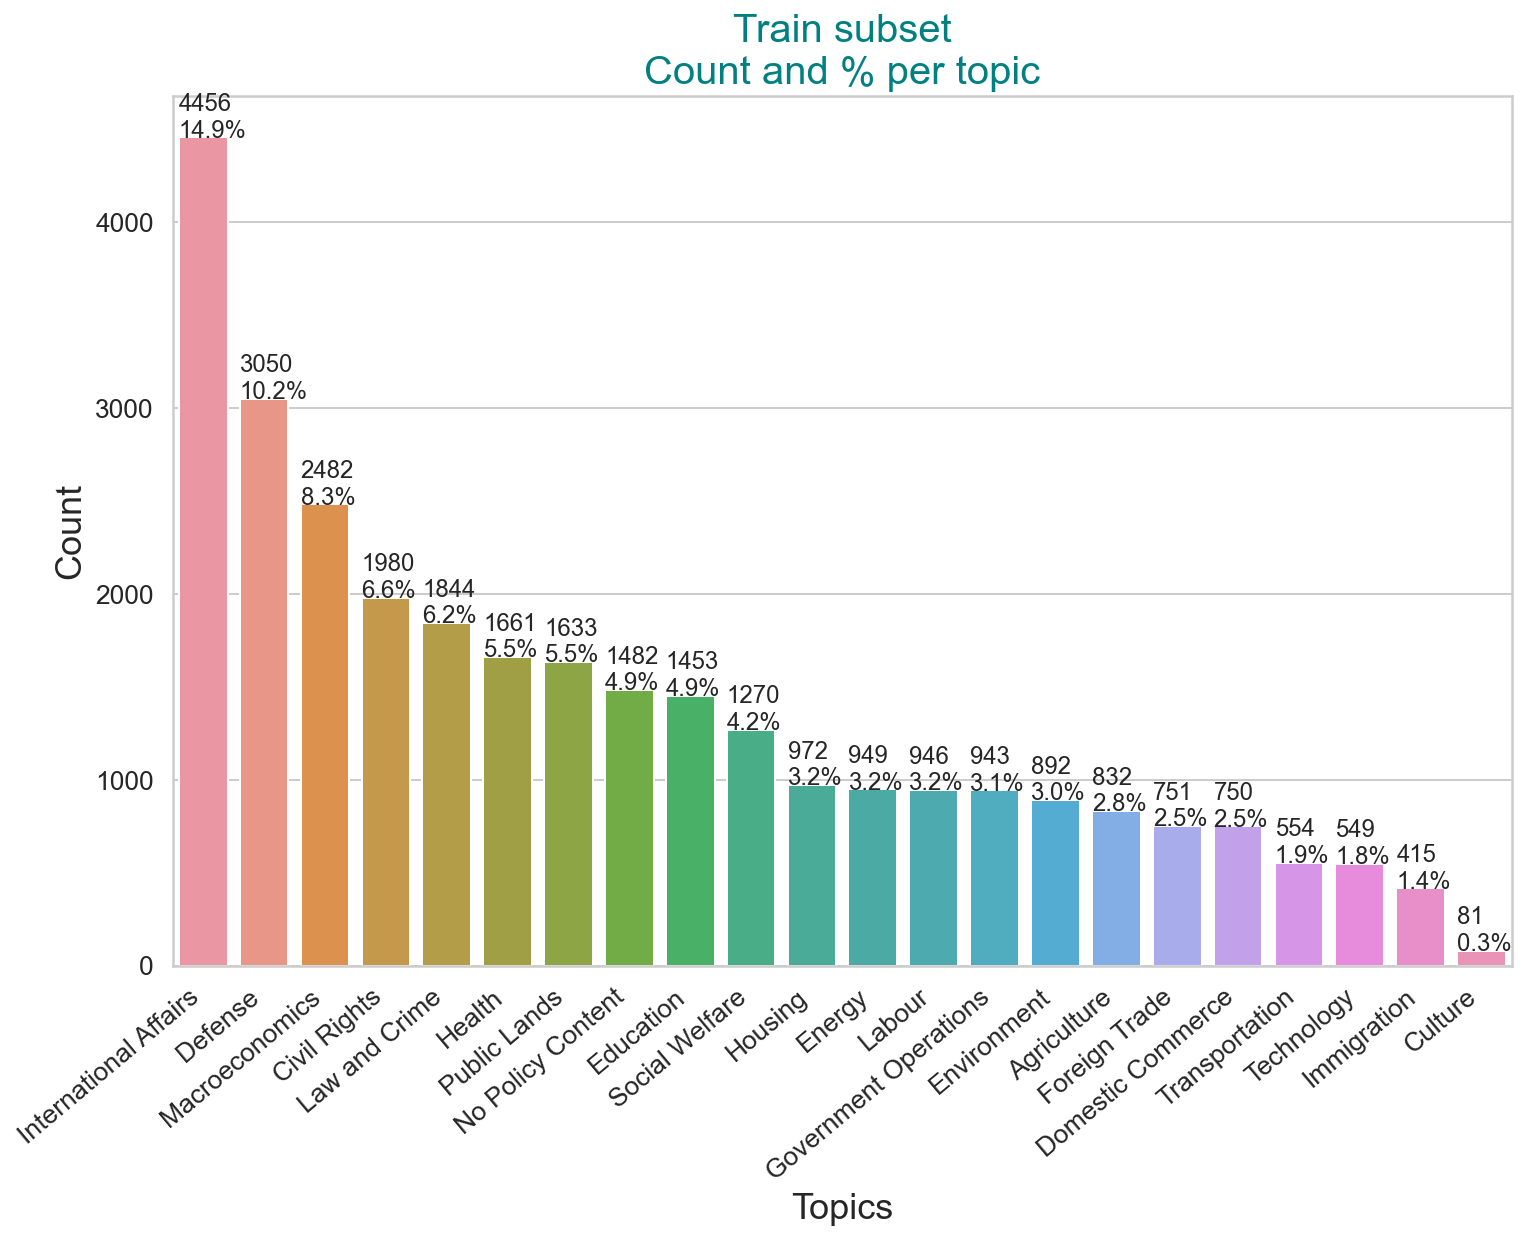

In [21]:
num=[]
percentage=[]
total=df_train.count()[0]
for i in range(len(class_names)):
    a=df_train[df_train.majortopic==i].count()[0]
    num.append(a)
    percentage.append(round(a/total*100,1))
train_counts=pd.DataFrame({"Major_Topic":class_names, "Count":num, "%_of_total":percentage})
sorted_train_counts=train_counts.sort_values("Count",ascending=False)

#And now, the plot:
ax = sns.barplot(x="Major_Topic", y="Count", data=sorted_train_counts)
plt.xlabel('Topics',fontsize =18)
plt.ylabel('Count',fontsize =18)
for p in ax.patches:
    porcentage=p.get_height()/total*100
    txt = str(int(p.get_height()))+"\n" + str((porcentage).round(1)) + "%"
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontsize=12)
plt.title('Train subset\nCount and % per topic', fontsize =20,color="teal")
ax.set_xticklabels(sorted_train_counts.Major_Topic,rotation=40, ha='right');

The topics in the training dataset are really imbalanced, as seen in the chart above, and some topics have a significantly lower number of examples than others. Thus, for those topics that have less than 1000 instances, I  append sentences from a different dataset (US State of the Union) so that the that the training dataset will have at least 1000 examples of each topic. *Note: this is not always possible, as for sometopics there are too few instances both in the training dataset we were using and in the us dataset we are adding rows from.*

In [22]:
us = pd.read_csv("us.csv")[["description","majortopic","year","id"]]
us.drop_duplicates(subset=['id'],inplace=True)
us.majortopic.value_counts()

-555    4221
 19     3233
 1      3231
 16     2922
 20     1145
 3      1037
 6       923
 5       846
 12      830
 13      776
 2       551
 18      538
 8       478
 4       376
 15      362
 7       305
 14      287
 17      285
 9       244
 10      225
 21      205
 23       17
Name: majortopic, dtype: int64

In [23]:
us.loc[us.majortopic==-555, "majortopic"] = 0

In [24]:
us.dropna(subset=['description', 'majortopic'],inplace=True)
us=us[us.description!=" "]
us["majortopic"] = np.array(list(map(lambda x: value_mapping[x], us["majortopic"])))

In [25]:
new_df=pd.DataFrame(columns=df_train.columns)

for i in df_train.majortopic.unique():
    
    current_rows=df_train[df_train.majortopic == i].count().majortopic
    new_df=pd.concat([new_df, df_train[df_train.majortopic == i]])
    if current_rows<1000:
      try:
          adding=us[us.majortopic==i].sample(1000-current_rows,random_state=RANDOM_SEED)
          adding["previous_description"]=""
          adding["long_description"]=""
          for index in adding.id:
            previous_sentence=us[us.id==(index-1)].description.values
            adding.loc[adding.id==index, "previous_description"] = previous_sentence
            adding.loc[adding.id==index, "long_description"] = adding.previous_description +  adding.description

          new_df=pd.concat([new_df, adding])

      except:
          adding=us[us.majortopic==i].copy()
          adding["previous_description"]=""
          adding["long_description"]=""
          for index in adding.id:
            previous_sentence=us[us.id==(index-1)].description.values
            try:
              adding.loc[adding.id==index, "previous_description"] = previous_sentence
              adding.loc[adding.id==index, "long_description"] = adding.previous_description +  adding.description  

            except:
              adding.loc[adding.id==index, "previous_description"] = ""
              adding.loc[adding.id==index, "long_description"] = adding.previous_description +  adding.description 
  
          adding.long_description==adding.previous_description +  adding.description 
          new_df=pd.concat([new_df, adding])


df_train=new_df.sample(frac=1).reset_index(drop=True)

**let's plot it again, to confirm we have some more examples in the categories with a low number of examples**

In [26]:
df_train.shape

(31968, 8)

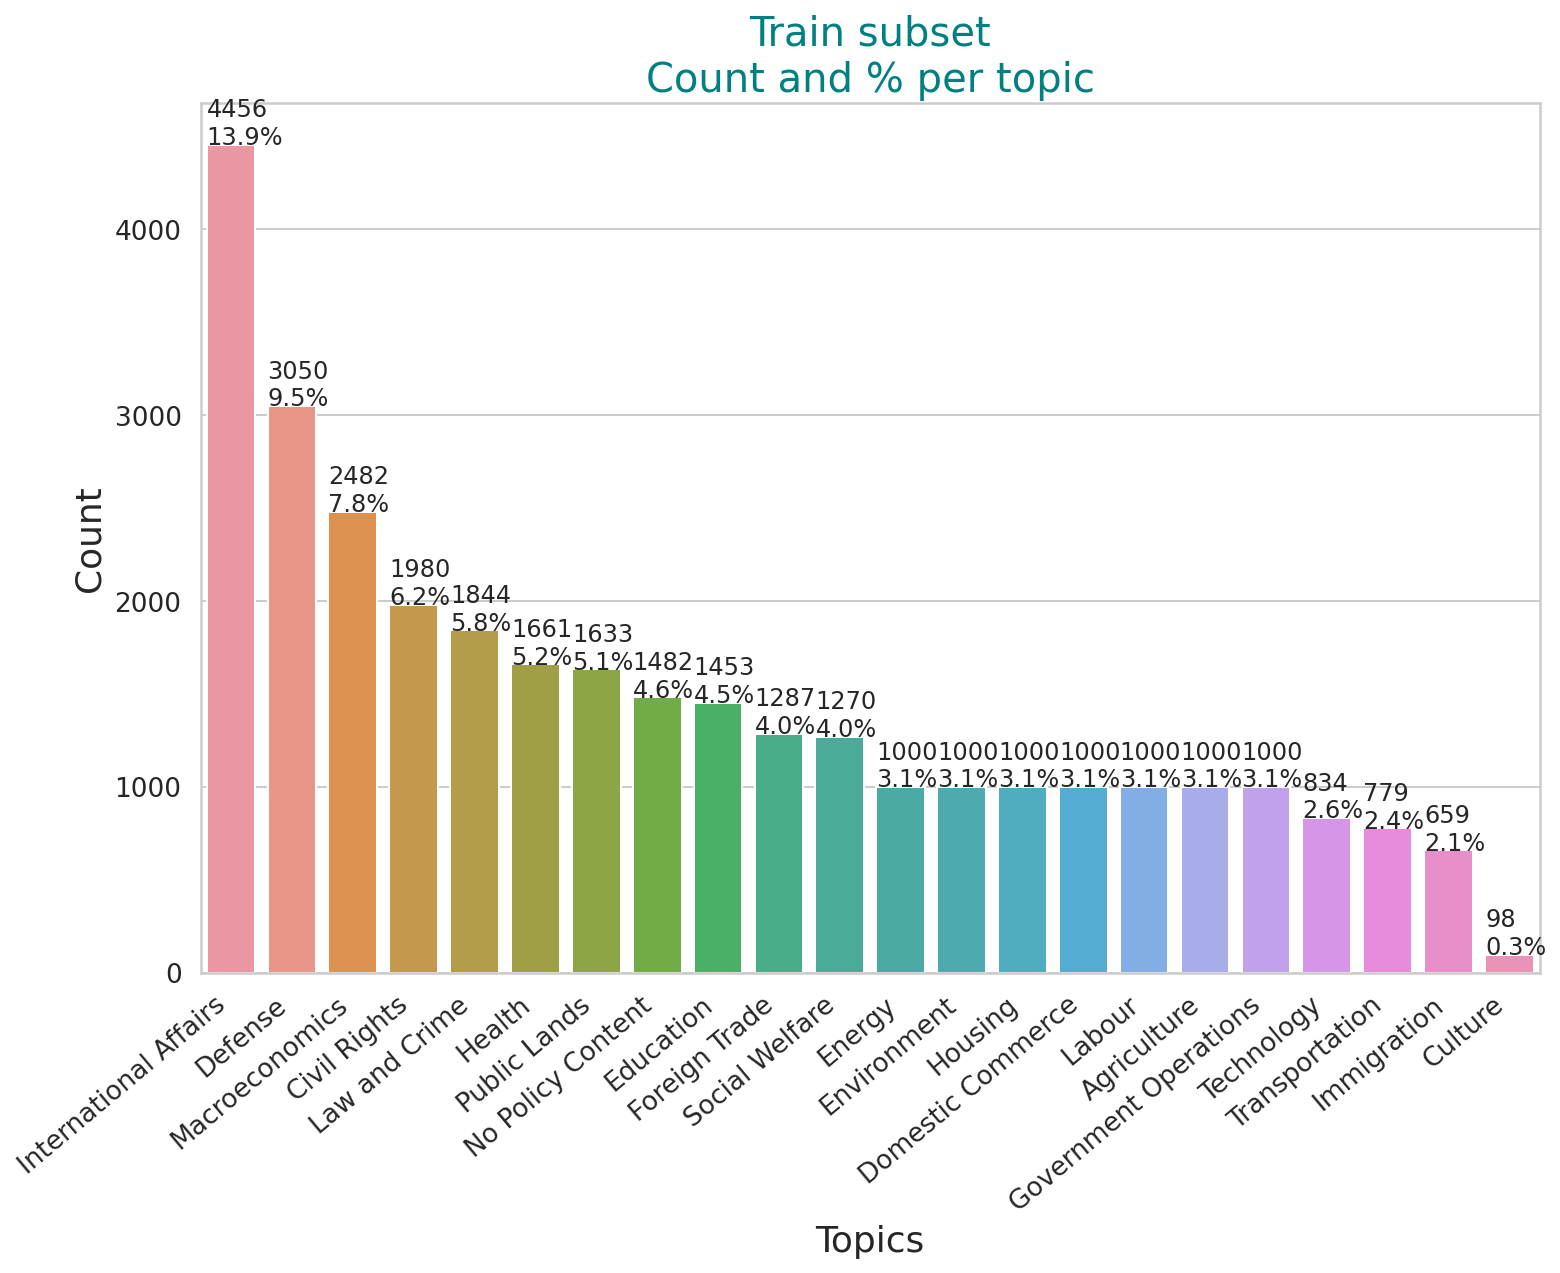

In [27]:
total=df_train.count()[0]
num=[]
percentage=[]
total=df_train.count()[0]
for i in range(len(class_names)):
    a=df_train[df_train.majortopic==i].count()[0]
    num.append(a)
    percentage.append(round(a/total*100,1))
train_counts=pd.DataFrame({"Major_Topic":class_names, "Count":num, "%_of_total":percentage})
sorted_train_counts=train_counts.sort_values("Count",ascending=False)

#And now, the plot:
ax = sns.barplot(x="Major_Topic", y="Count", data=sorted_train_counts)
plt.xlabel('Topics',fontsize =18)
plt.ylabel('Count',fontsize =18)
for p in ax.patches:
    porcentage=p.get_height()/total*100
    txt = str(int(p.get_height()))+"\n" + str((porcentage).round(1)) + "%"
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontsize=12)
plt.title('Train subset\nCount and % per topic', fontsize =20,color="teal")
ax.set_xticklabels(sorted_train_counts.Major_Topic,rotation=40, ha='right');


## BERT- Data Preprocessing


In [28]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [29]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [30]:
token_lens = []

for idx, txt in enumerate(df_train.long_description):
  try:
    tokens = tokenizer.encode(txt, max_length=512,truncation=True)
    token_lens.append(len(tokens))
  except:
    print("emptyvalue")
    print (txt)
    print (idx)
  

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


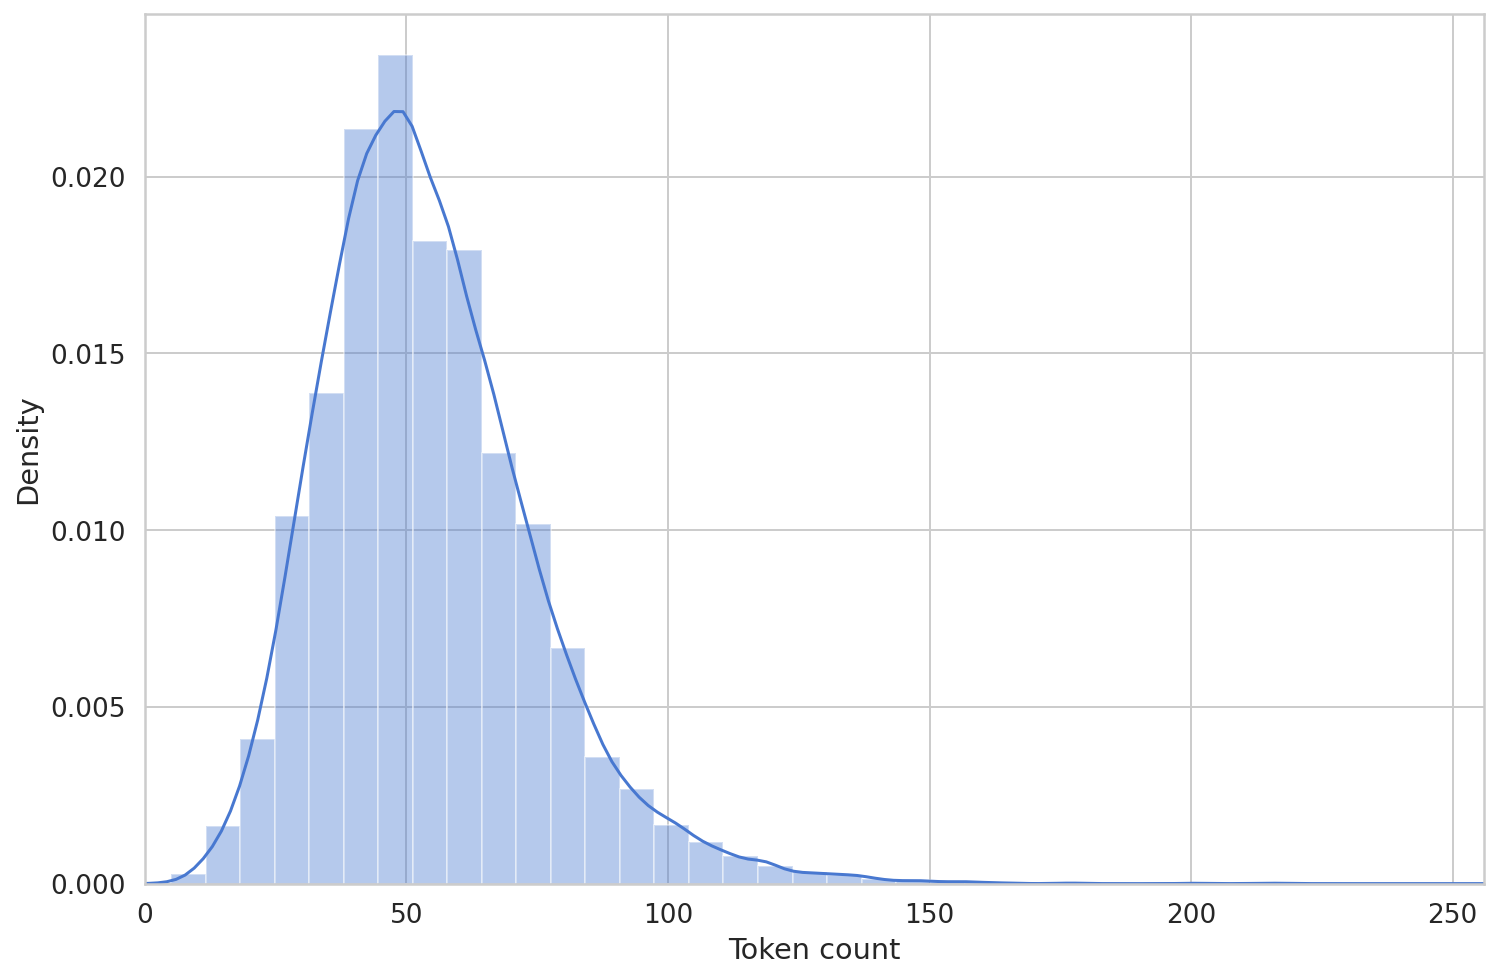

In [31]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Given the chart above, I will select a maximum lenght of 150 tokens.
.

In [32]:
MAX_LEN =150

Creation of the PyTorch dataset class:

In [33]:
class GPDataset(Dataset):

  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sentence': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

And now I create the dataloader function

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPDataset(
    sentences=df.long_description.to_numpy(),
    targets=df.majortopic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

Now, I use to function I just created to send my three dataframes (Training, Validation and Test) to their respective DataLoaders, using a batch_size of 32 and the maximun length of 100, as shown before.

In [35]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Classification with BERT and Hugging Face

This classifier is built on top of a basic Bert model, using Hugging Face. I use dropout of 0.5

In [36]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [37]:
class TopicClassifier(nn.Module):

  def __init__(self, n_classes):
    super(TopicClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.5)
    self.fc1=nn.Linear (self.bert.config.hidden_size, 256)
    self.out = nn.Linear(256, n_classes)
  
  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output= self.fc1(output)
    output = nn.functional.relu(output)
    return self.out(output)

In [38]:
model = TopicClassifier(len(class_names))
model = model.to(device)

In [39]:
data = next(iter(train_data_loader))
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 150])
torch.Size([32, 150])


### Training

I selected 10 Epochs, the Adam optimizer, a learning rate of 3e-5 and no warmup steps.

In [40]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

The following function trains one epoch:

In [41]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

The following funtions evaluates the performance of the model in a specific dataset (dataloader):

In [42]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Below is the training loop, which makes use of the two funcitons created above: eval_model and train_epoch.

In [43]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  #if val_acc > best_accuracy:
    #torch.save(model.state_dict(), 'best_model_state_parties.bin')
    #best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.4741484168711845 accuracy 0.6292855355355356
Val   loss 0.9287535106269722 accuracy 0.7576084029086991

Epoch 2/10
----------
Train loss 0.6030884149285766 accuracy 0.8470032532532532
Val   loss 0.9516198987889494 accuracy 0.7640721788311339

Epoch 3/10
----------
Train loss 0.36339918557588047 accuracy 0.9083458458458459
Val   loss 0.9824262328891673 accuracy 0.7708052787503367

Epoch 4/10
----------
Train loss 0.225751796875287 accuracy 0.9440377877877878
Val   loss 1.1226070272282531 accuracy 0.767034742795583

Epoch 5/10
----------
Train loss 0.14622835545531204 accuracy 0.9635885885885885
Val   loss 1.234253292477443 accuracy 0.7745758147050902

Epoch 6/10
----------
Train loss 0.0919820857775007 accuracy 0.9787912912912913
Val   loss 1.3648255535154643 accuracy 0.7699973067600323

Epoch 7/10
----------
Train loss 0.06127734336798341 accuracy 0.9854229229229229
Val   loss 1.4405416785669711 accuracy 0.7783463506598438

Epoch 8/10
----------
Train loss 0.04075577150010

In [44]:
#if we already have a saved trained model, we can load it with the following lines, insted of training it:
#model = TopicClassifier(len(class_names))
#model.load_state_dict(torch.load('best_model_state_parties.bin'))
#model = model.to(device)

## Evaluation

First I will calculating the accuracy of the trained bert model on the test split

In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.790833999467093

The following function returns the predictions:

In [46]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sentences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sentence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sentences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentences, predictions, prediction_probs, real_values

Using this function we can get the predictions of our model and contrast them with the real topic.

In [47]:
y_sentences, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [48]:
print(classification_report(y_test, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

    No Policy Content       0.80      0.60      0.69       311
       Macroeconomics       0.78      0.82      0.80       264
         Civil Rights       0.57      0.76      0.65       152
               Health       0.87      0.89      0.88       274
          Agriculture       0.81      0.85      0.83        40
               Labour       0.75      0.72      0.73       134
            Education       0.92      0.91      0.92       267
          Environment       0.71      0.75      0.73        85
               Energy       0.89      0.86      0.88        58
          Immigration       0.73      0.87      0.80        38
       Transportation       0.62      0.93      0.75        30
        Law and Crime       0.76      0.68      0.72       331
       Social Welfare       0.80      0.73      0.76       168
              Housing       0.86      0.89      0.87        88
    Domestic Commerce       0.62      0.54      0.58  

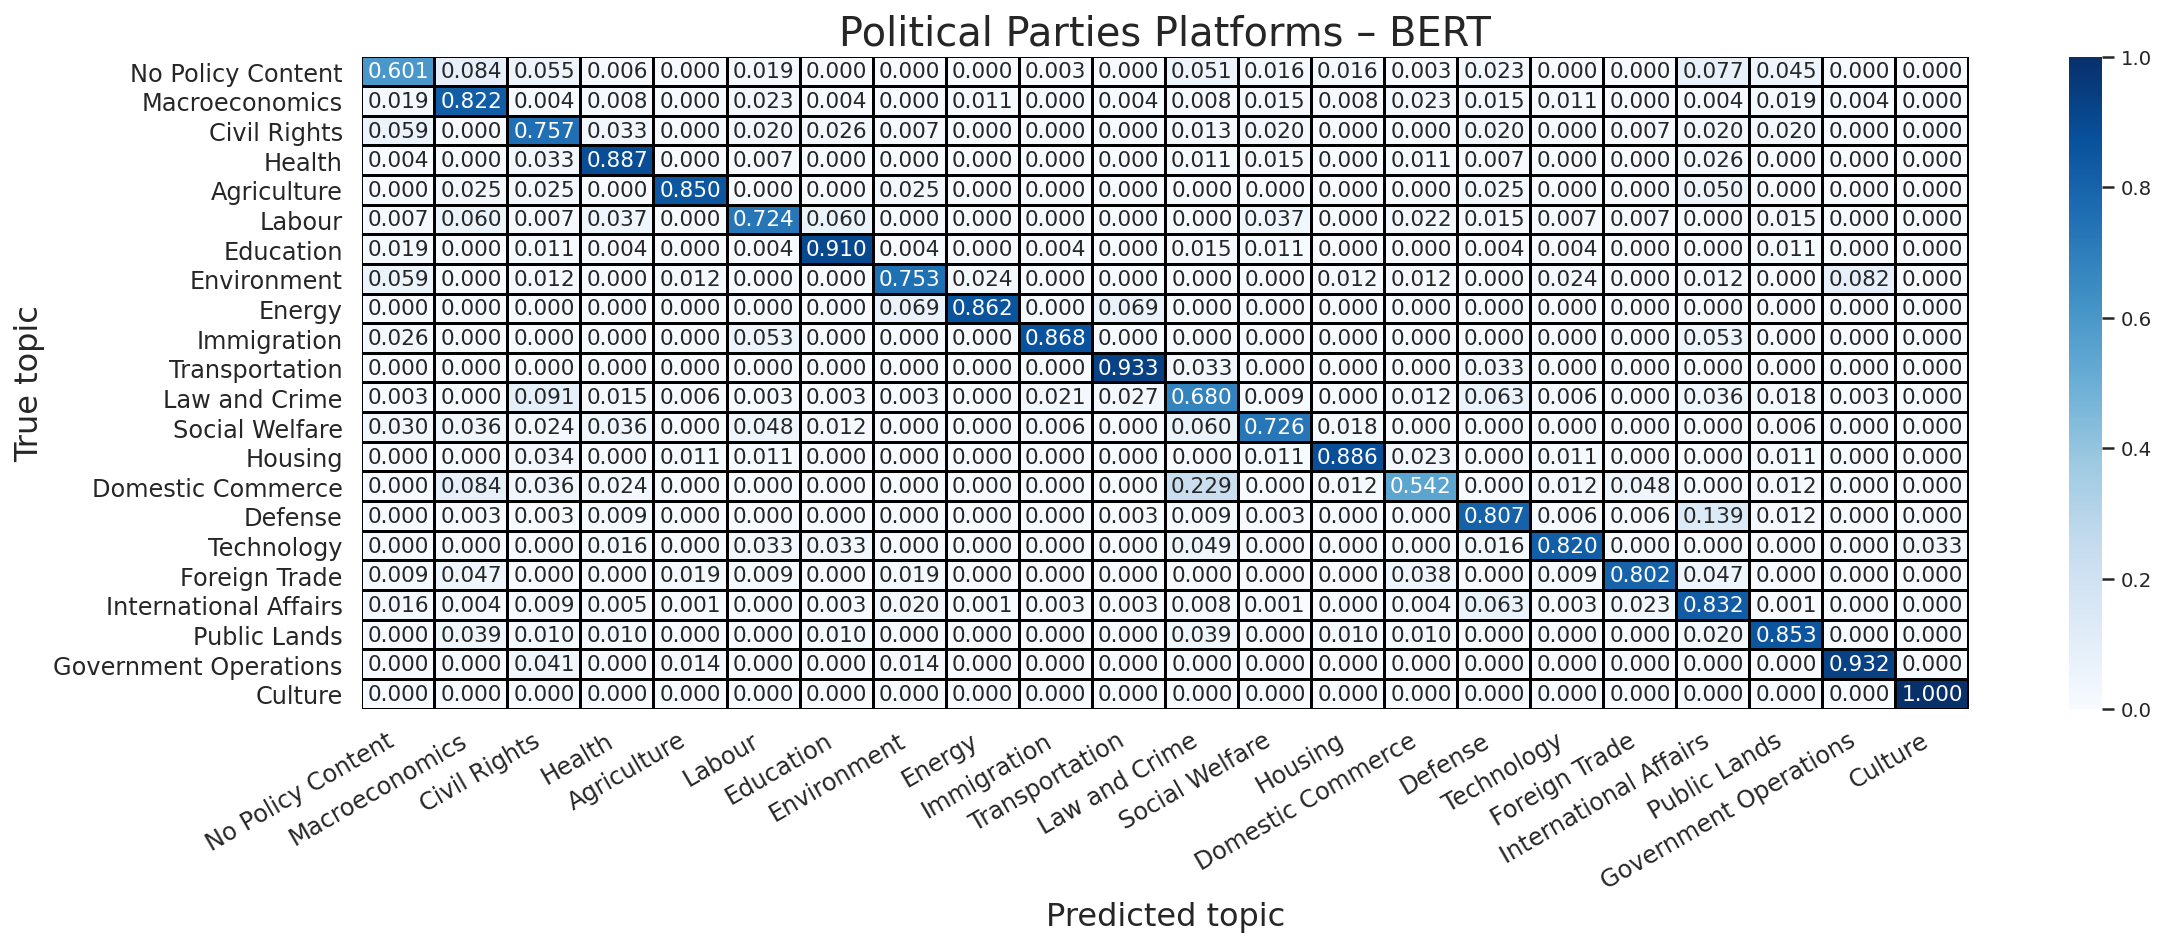

In [49]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize = (18,6))
  sns. set(font_scale=0.9)
  hmap = sns.heatmap(confusion_matrix, annot=True,fmt='.3f', cmap="Blues", linewidths=1, linecolor='black')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right',size=12)
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right',size=12)
  plt.ylabel('True topic',fontdict={"size":16})
  plt.title('Political Parties Platforms – BERT', fontsize =20)
  plt.xlabel('Predicted topic',fontdict={"size":16});

cm = confusion_matrix(y_test, y_pred,normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

**-------Let's see some examples--------------**

In [50]:
import random

In [51]:
idx = random.randrange(len(y_sentences))
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})


print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')

Today more than 63 million Americans are answering the call to serve..
The number of volunteers has increased by 4 million since 2002.

True topic: Social Welfare


Now we can look at the confidence of each topic of our model:

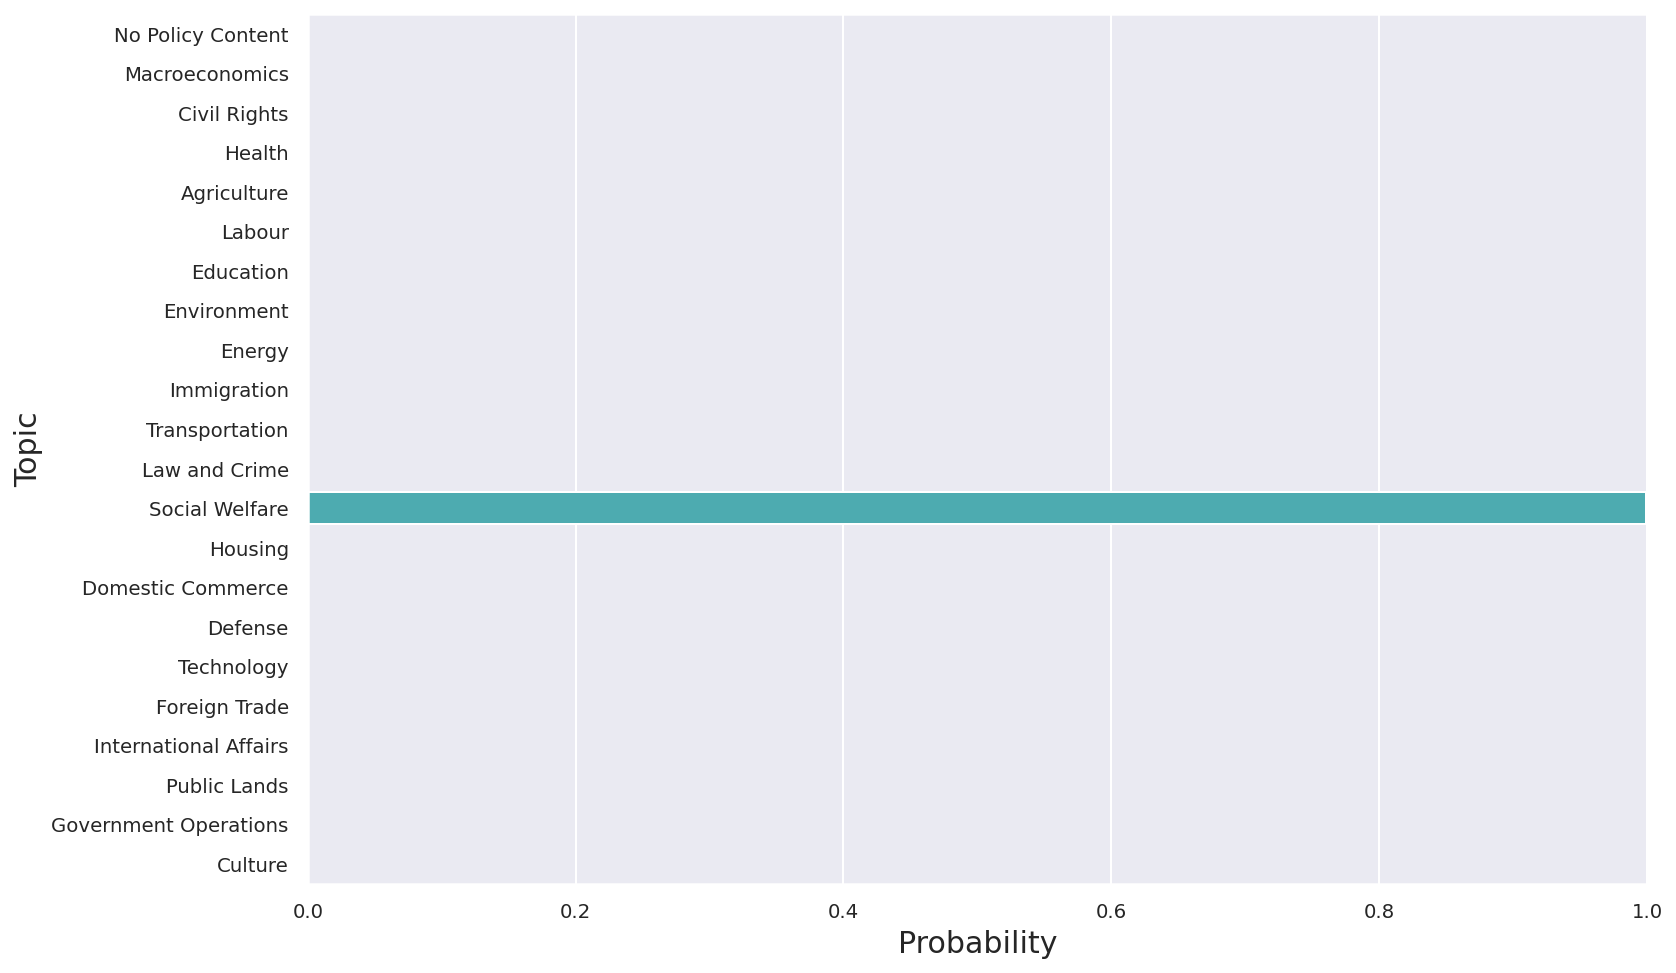

In [52]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

**another example...**

On the public side, Democrats believe in doubling the current levels
of investment in information technology research and biomedical
research and supporting the continued development of the Next
Generation Internet - moving 1,000 times faster than today's
Internet.. We believe in helping universities and federal laboratories
become centers of innovation that support and catalyze private sector
growth.

True topic: Technology


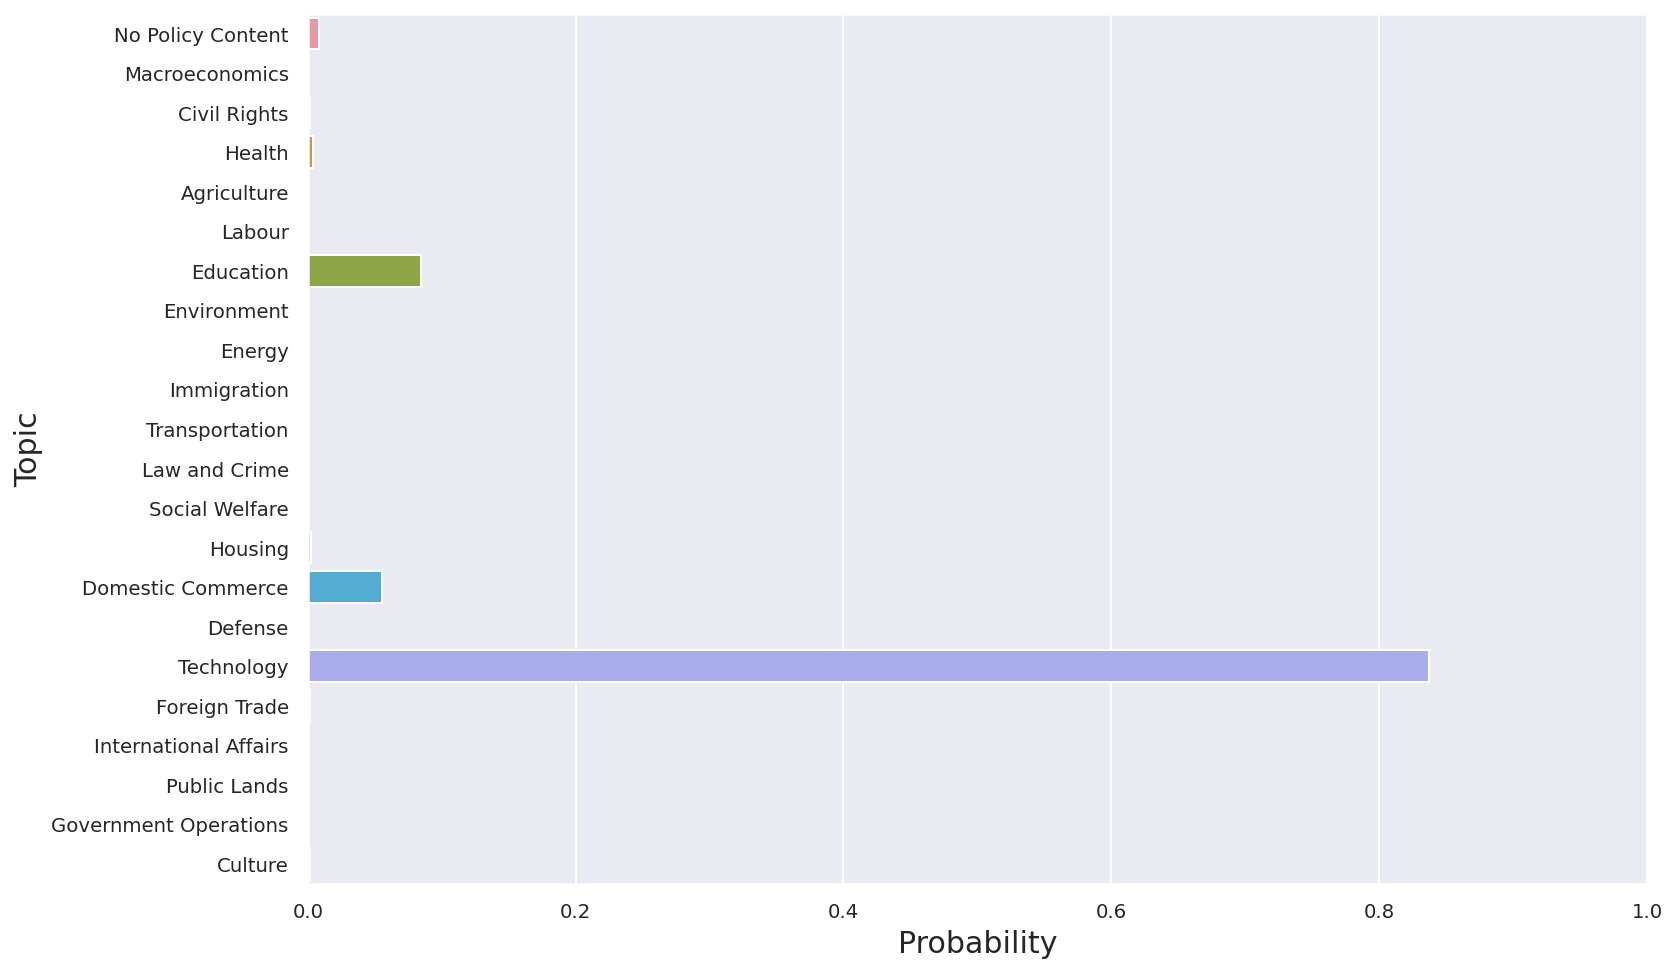

In [53]:
idx = random.randrange(len(y_sentences))
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})


print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

Let's see a number of examples of sentences that went wrong:

not a race to the bottom, but a dash to the top;. about a rising tide
lifting the boats of workers here and abroad;

True topic: Foreign Trade


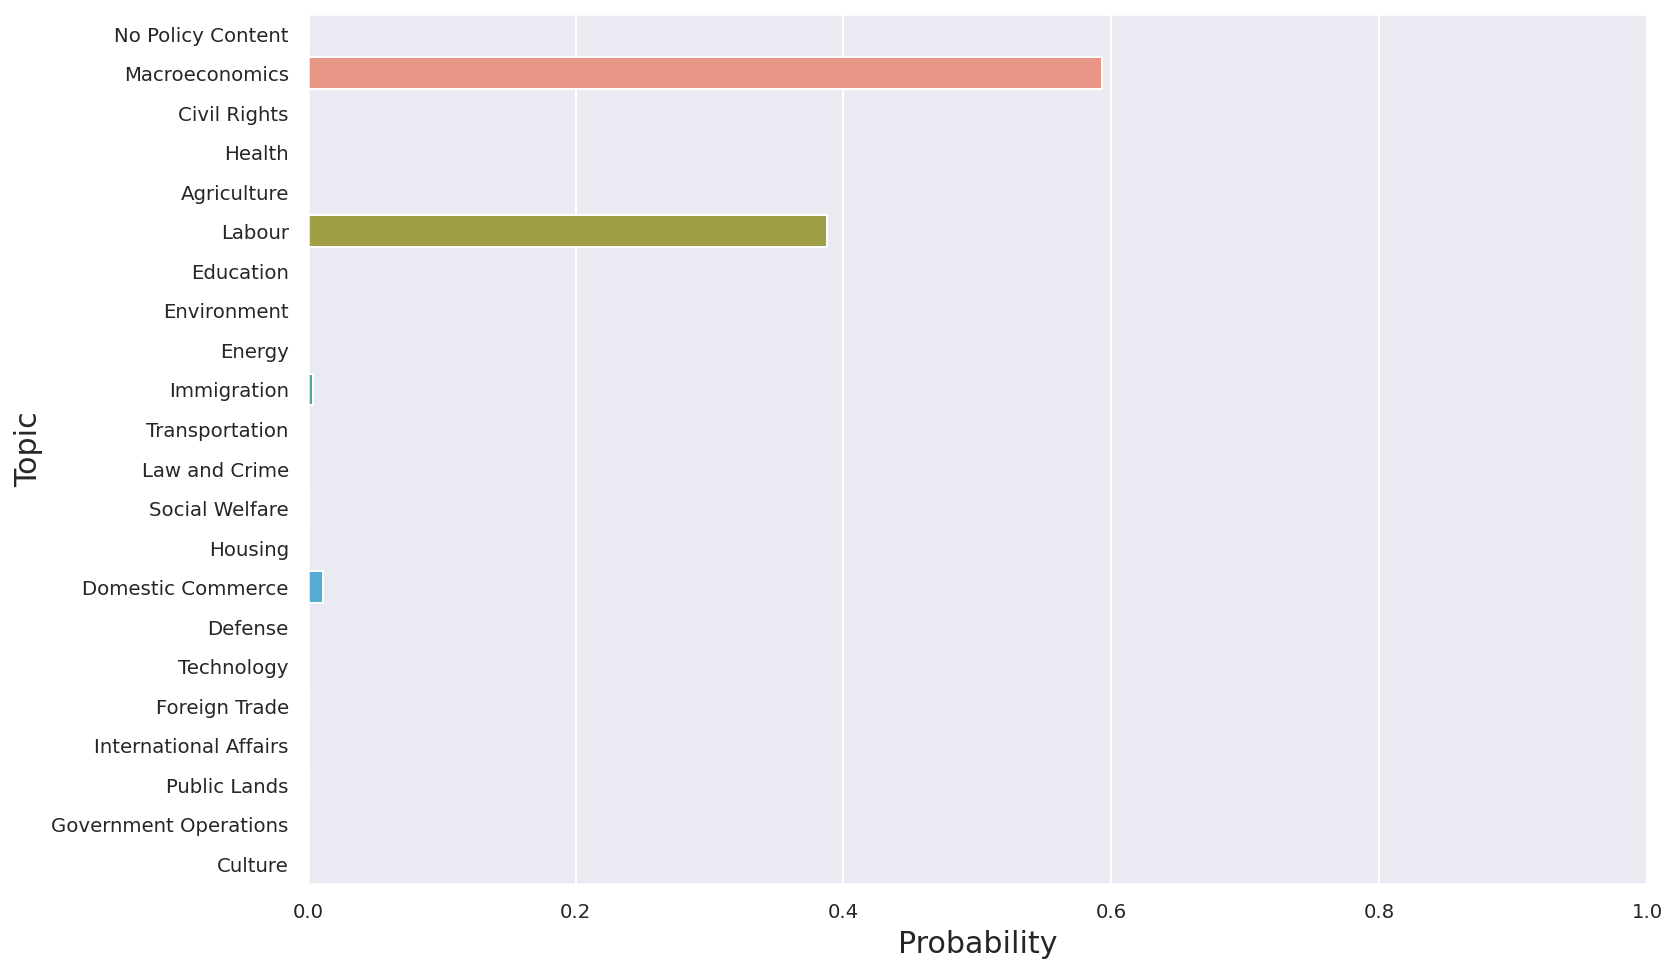

In [54]:
#let's see examples of those sentences that belong to Foreign Trade, that were classified as Macroeconomics
wrong_sentences_trade=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==17 and y_pred[idx]==1:
    wrong_sentences_trade.append(idx)
idx = random.choice(wrong_sentences_trade)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

America was the pioneer of universal education;. now America must
become the pioneer of universal computer literacy.

True topic: Technology


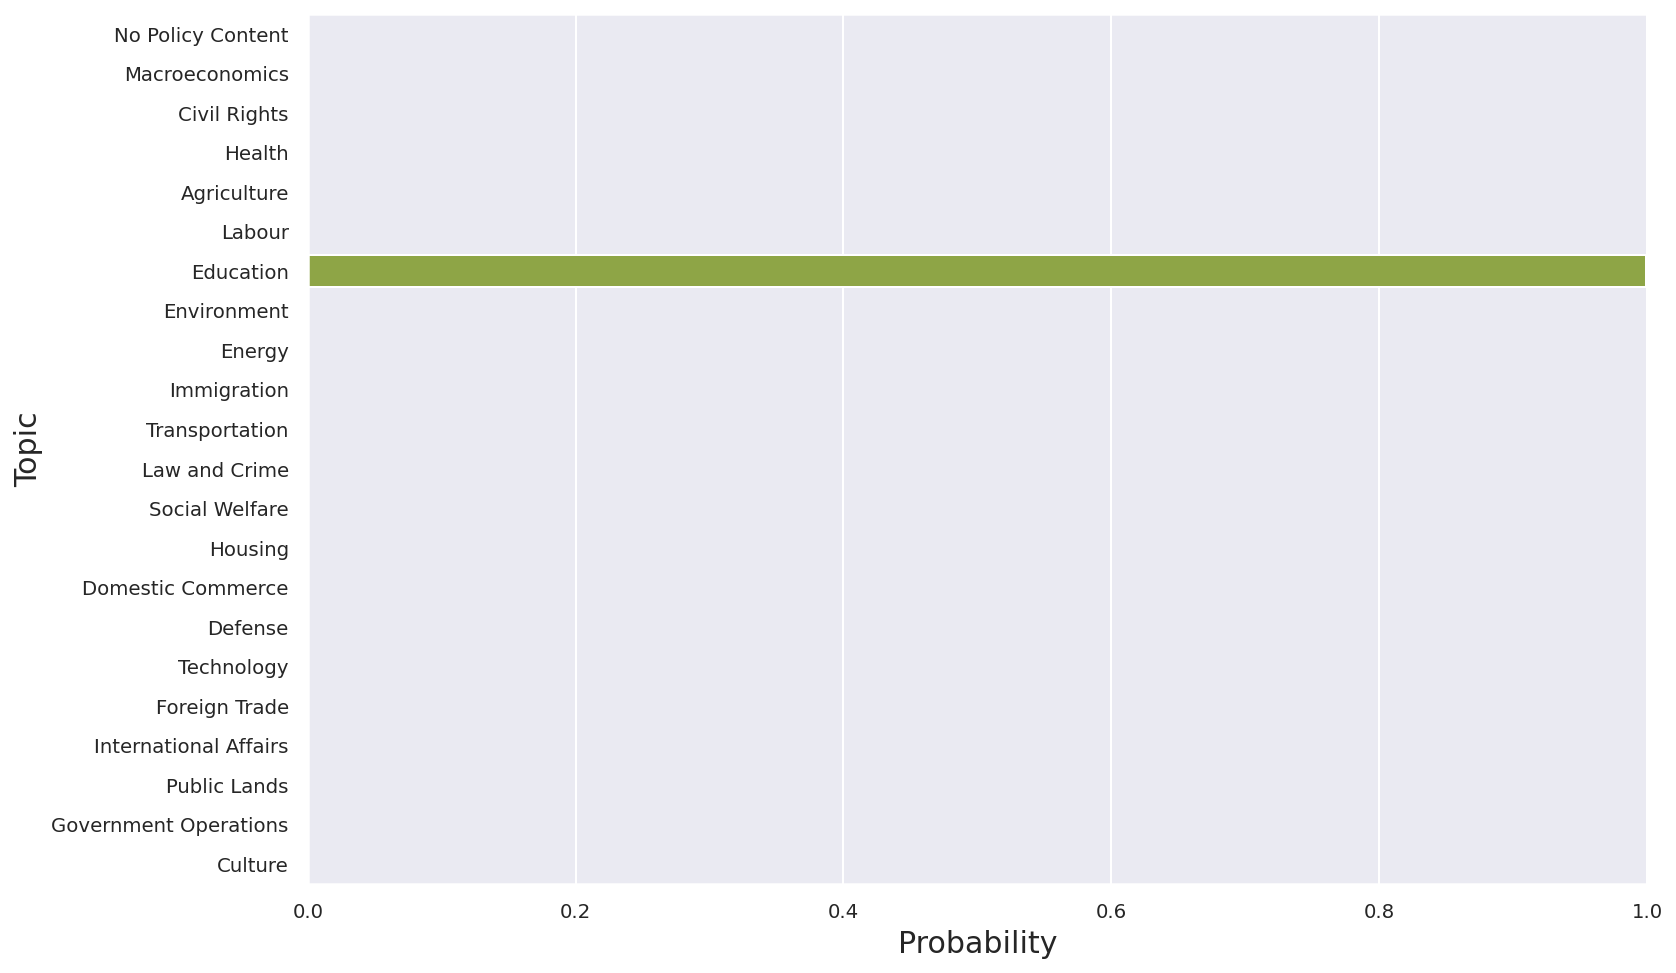

In [55]:
#let's see examples of those sentences that belong to Technology, that were classified as Education
wrong_sentences_tec=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==16 and y_pred[idx]==6:
    wrong_sentences_tec.append(idx)
idx = random.choice(wrong_sentences_tec)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

The United States and our coalition partners are helping prepare
Iraqis for the defense of their own country, including through the
work of the NATO mission to train Iraqi security forces.. We are
helping Iraqis rebuild their country√≠¬¥s infrastructure, and Iraq is
continuing to move toward free elections, with important assistance
from the United Nations.

True topic: Defense


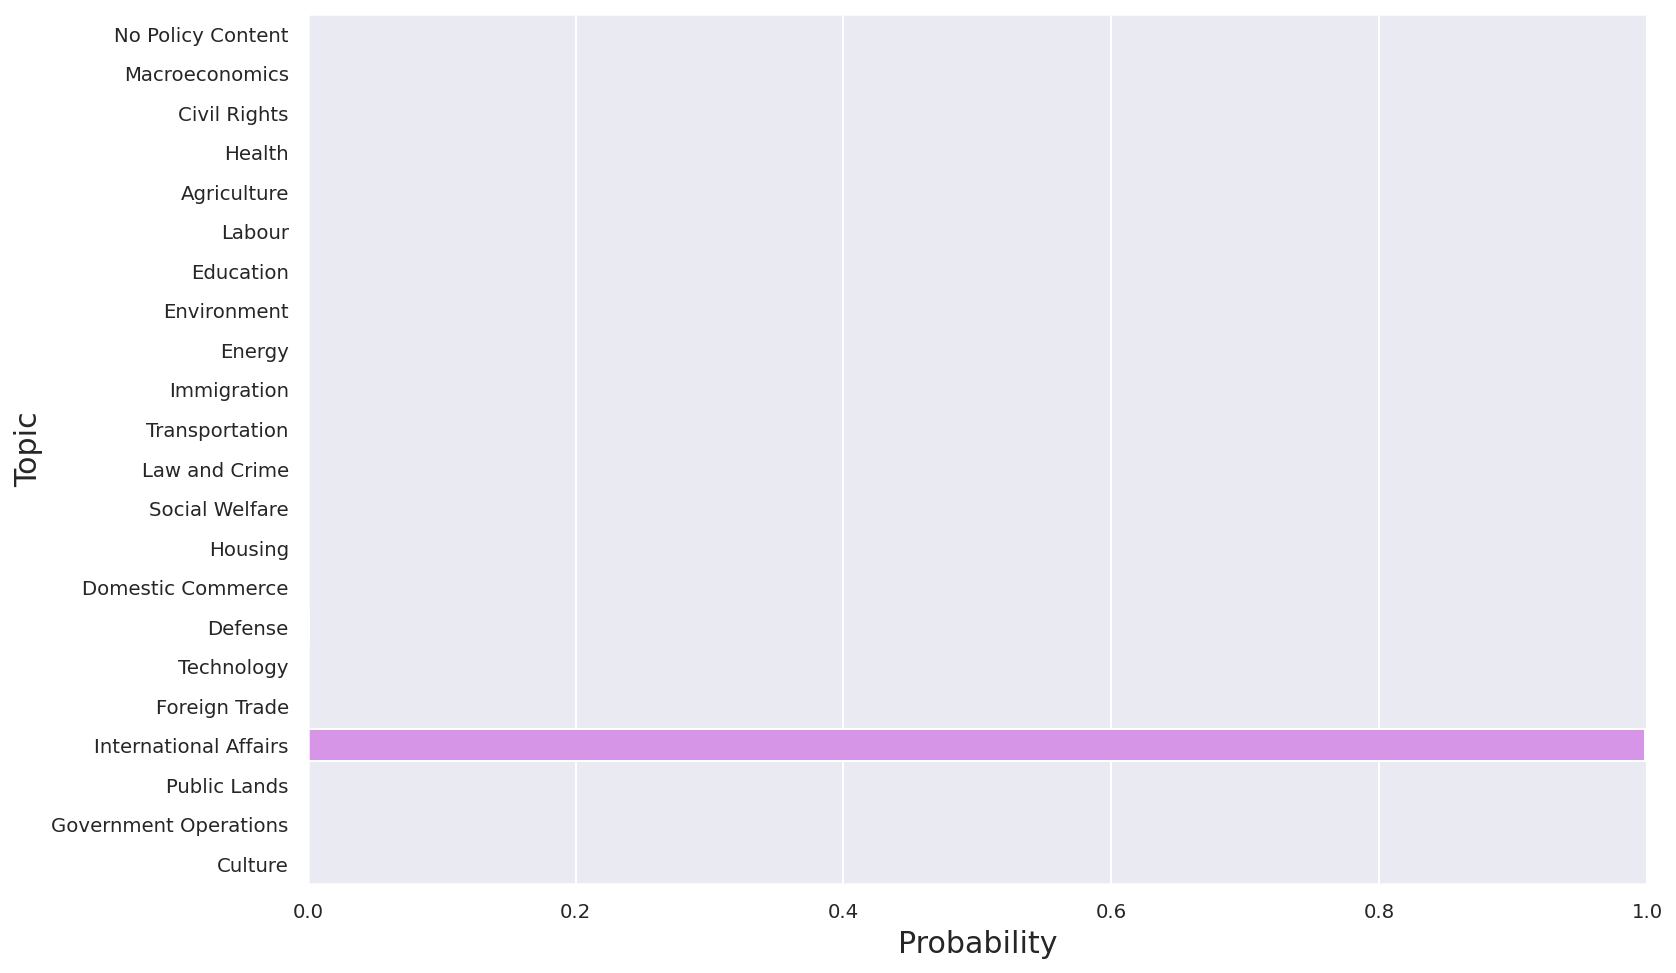

In [56]:
#let's see examples of those sentences that belong to Defense, that were classified as International Affairs
wrong_sentences_defense=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==15 and y_pred[idx]==18:
    wrong_sentences_defense.append(idx)
idx = random.choice(wrong_sentences_defense)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

We will end "second-best" weapons policies.. We will end the false
economies which place price ahead of the performance upon which
American lives may depend.

True topic: Defense


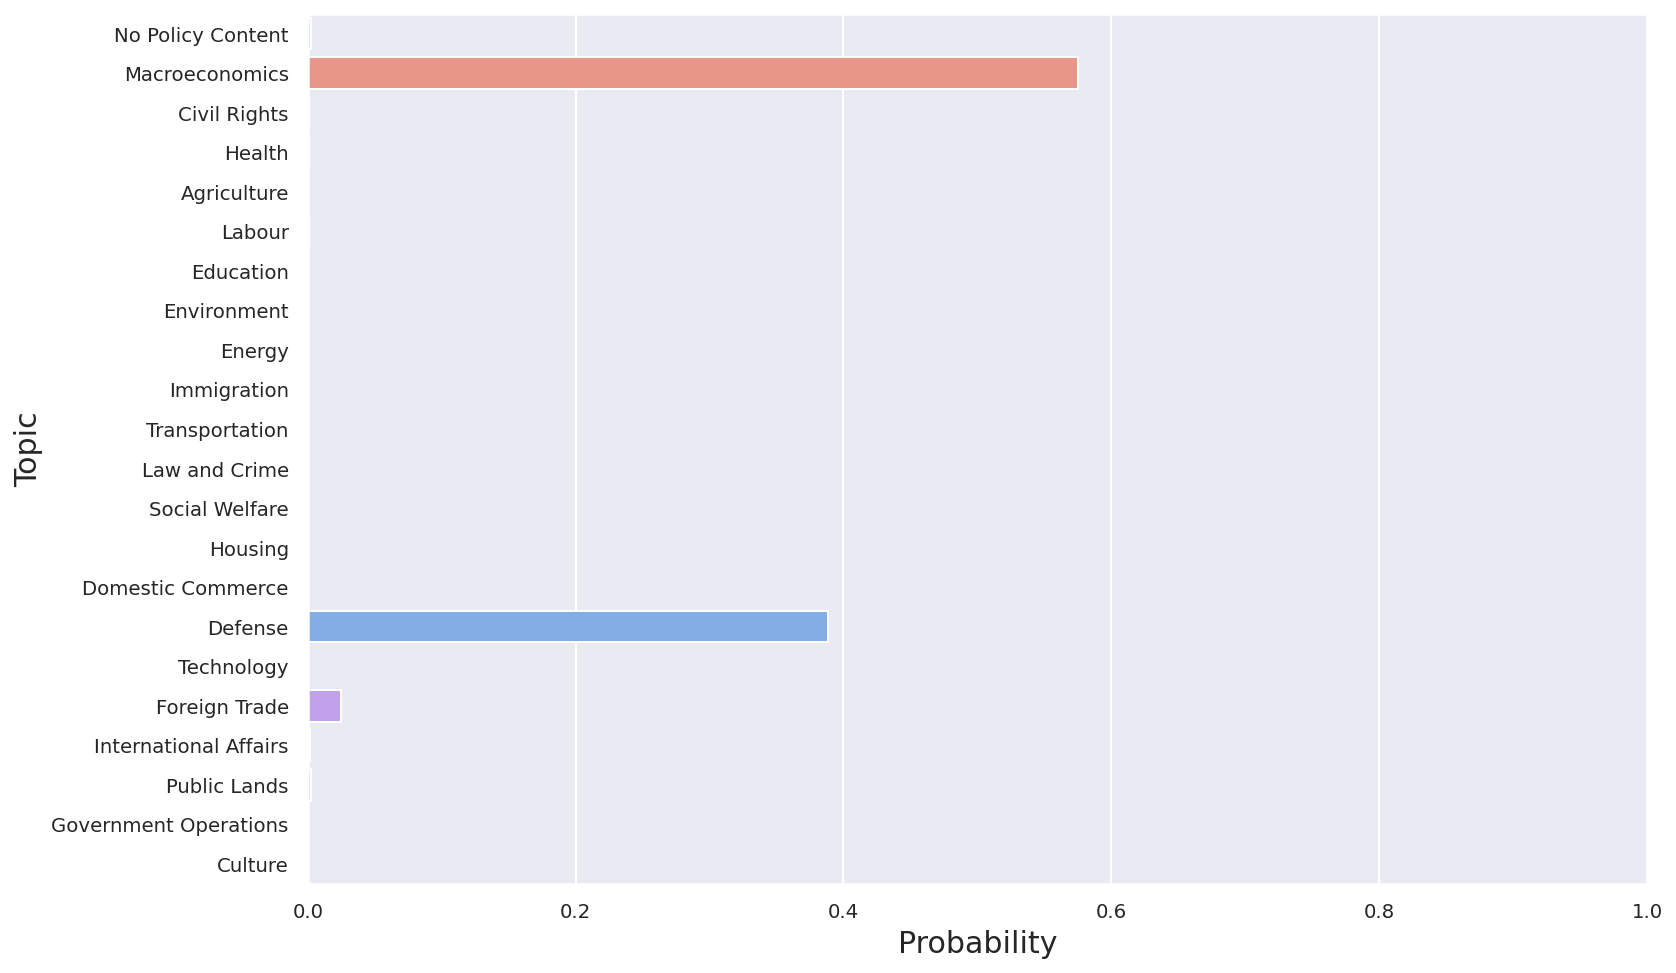

In [57]:
#let's see examples of those sentences that belong to Defense, that were classified as Law and Crime
wrong_sentences=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==15 and y_pred[idx]==1:
    wrong_sentences.append(idx)

idx = random.choice(wrong_sentences)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

President Bush created the National Do Not Call Registry, a tool that
will help ensure that telemarketers respect the privacy of our
nation√≠¬¥s citizens.. It will allow people to limit most unwanted
telemarketing calls by registering their home or cell phone numbers.

True topic: Domestic Commerce


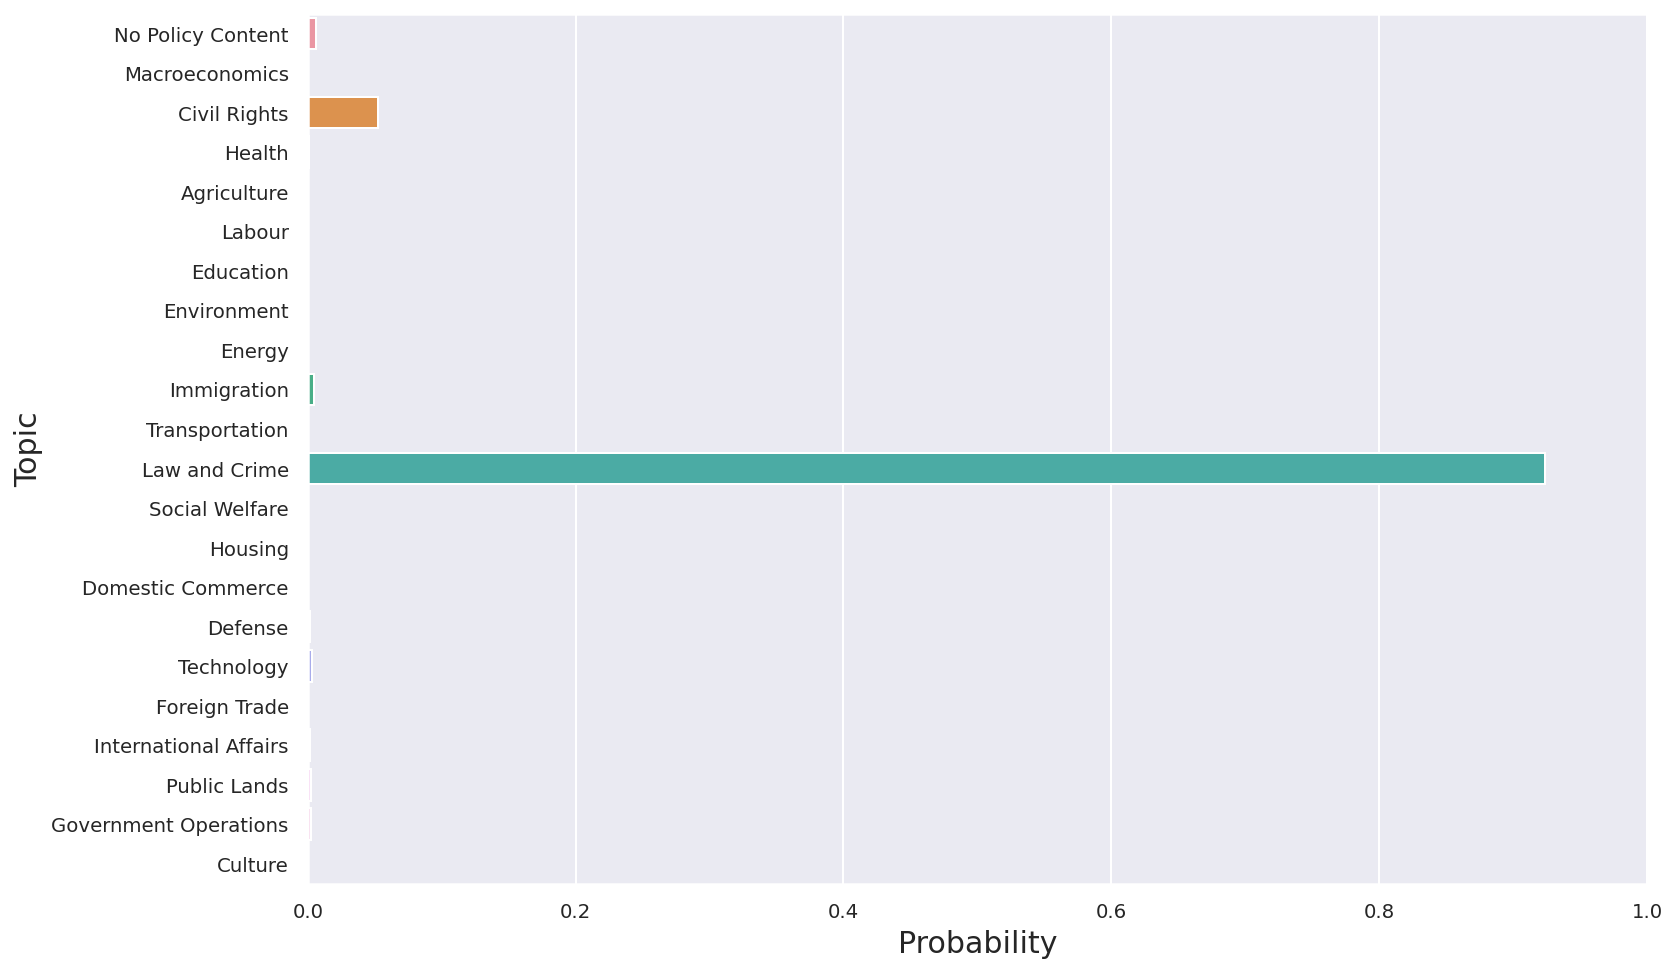

In [58]:
#let's see examples of those sentences that belong to commerce, that were classified as Law and Crime
wrong_sentences=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==14 and y_pred[idx]==11:
    wrong_sentences.append(idx)

idx = random.choice(wrong_sentences)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

Junk and frivolous lawsuits are driving up the cost of doing business
in America by forcing companies to pay excessive legal expenses to
fight off or settle often baseless lawsuits.. Those costs are being
paid by small business owners, manufacturers, their employees, and
consumers.

True topic: Domestic Commerce


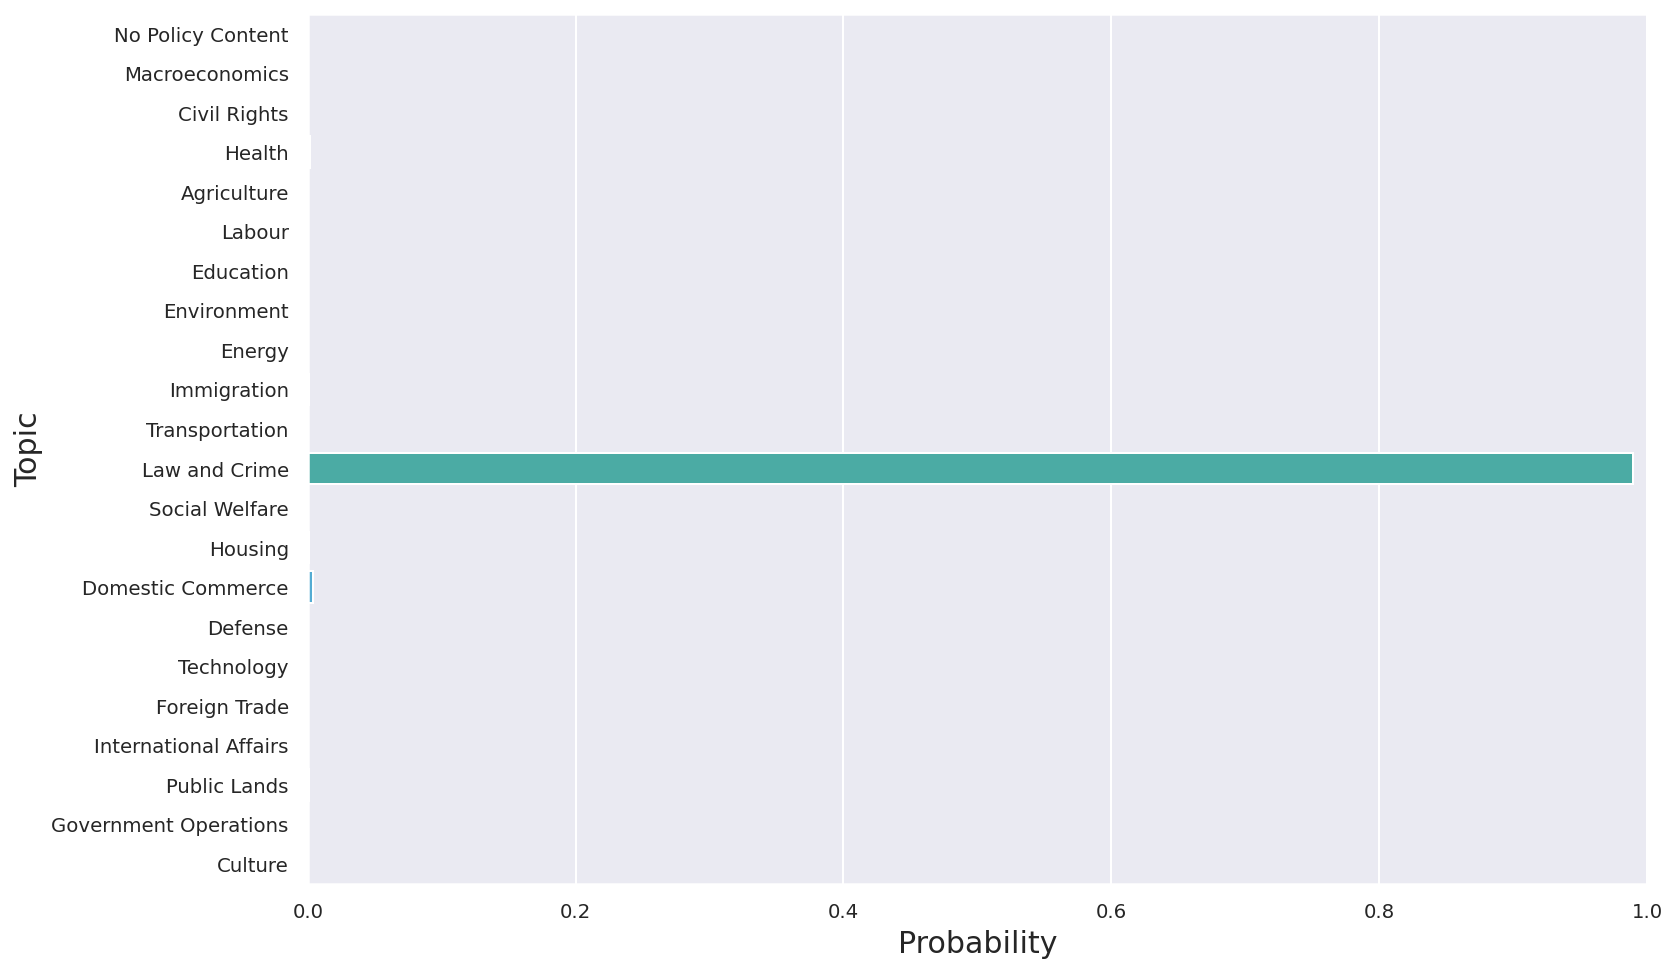

In [59]:
wrong_sentences=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==14 and y_pred[idx]==11:
    wrong_sentences.append(idx)

idx = random.choice(wrong_sentences)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

The crime of identity theft undermines the basic trust on which our
economy depends.. And like other forms of stealing, identity theft
leaves the victim poorer and feeling terribly violated.

True topic: Domestic Commerce


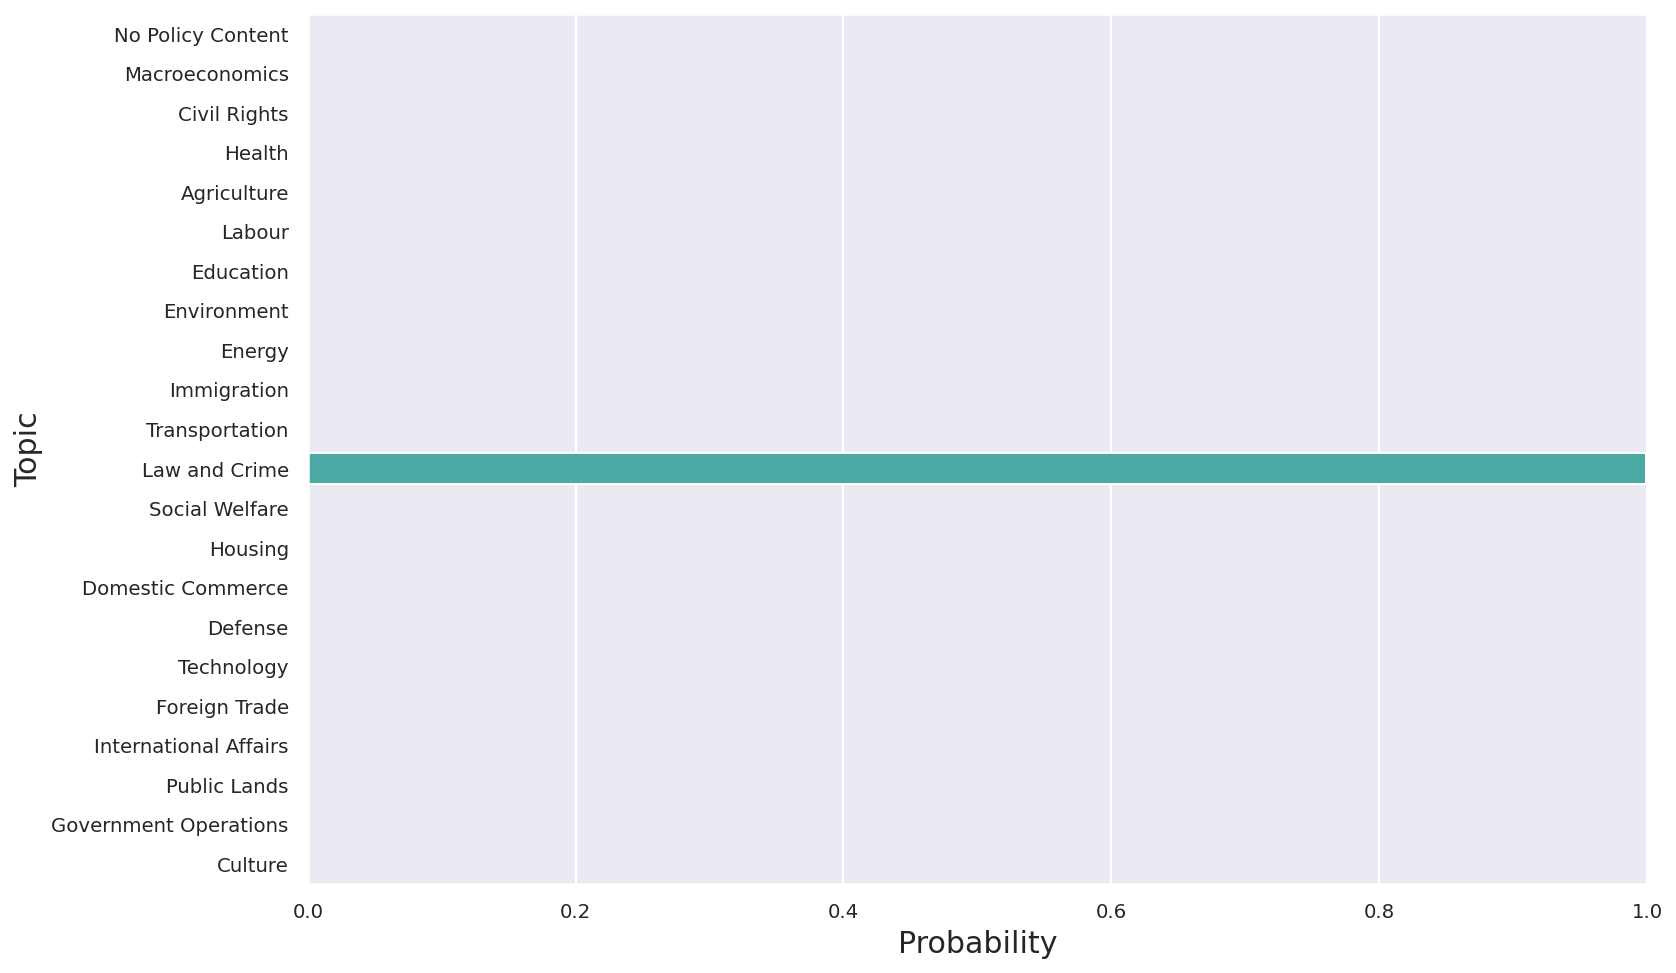

In [60]:
wrong_sentences=[]
for idx in range(len(y_sentences)):
  if y_test[idx]==14 and y_pred[idx]==11:
    wrong_sentences.append(idx)

idx = random.choice(wrong_sentences)
sentence = y_sentences[idx]
true_topic = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(sentence)))
print()
print(f'True topic: {class_names[true_topic]}')
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Topic',size=15)
plt.xlabel('Probability',size=15)
plt.xlim([0, 1]);

Now, let't try to see what happens if we want to use this model as is to classify info from the UK, Speeches from the Throne

-----------------------------------------------

In [61]:
add_previous(uk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [62]:
uk.head()

,id,majortopic,year,description,long_description
0,1,0,1911,"My Lords, and Gentlemen,","My Lords, and Gentlemen,"
1,2,0,1911,In opening the first Parliament elected in My ...,"My Lords, and Gentlemen,. In opening the first..."
2,3,0,1911,"When, a year ago, He addressed you from the Th...",In opening the first Parliament elected in My ...
3,4,0,1911,Bowing to the inscrutable decree of Providence...,"When, a year ago, He addressed you from the Th..."
4,5,0,1911,"I have welcomed back My Uncle, the Duke of Con...",Bowing to the inscrutable decree of Providence...


In [63]:
uk_test_data_loader = create_data_loader(uk, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [64]:
y_sentences, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  uk_test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [65]:
print(classification_report(y_test, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

    No Policy Content       0.66      0.29      0.40       482
       Macroeconomics       0.66      0.58      0.62       586
         Civil Rights       0.39      0.45      0.41       112
               Health       0.71      0.72      0.72       138
          Agriculture       0.68      0.68      0.68       198
               Labour       0.50      0.46      0.48       217
            Education       0.81      0.83      0.82       213
          Environment       0.55      0.44      0.49        81
               Energy       0.69      0.77      0.73        97
          Immigration       0.38      0.88      0.53        24
       Transportation       0.70      0.80      0.75       169
        Law and Crime       0.77      0.67      0.71       351
       Social Welfare       0.52      0.46      0.49       192
              Housing       0.63      0.59      0.61       217
    Domestic Commerce       0.60      0.52      0.56  

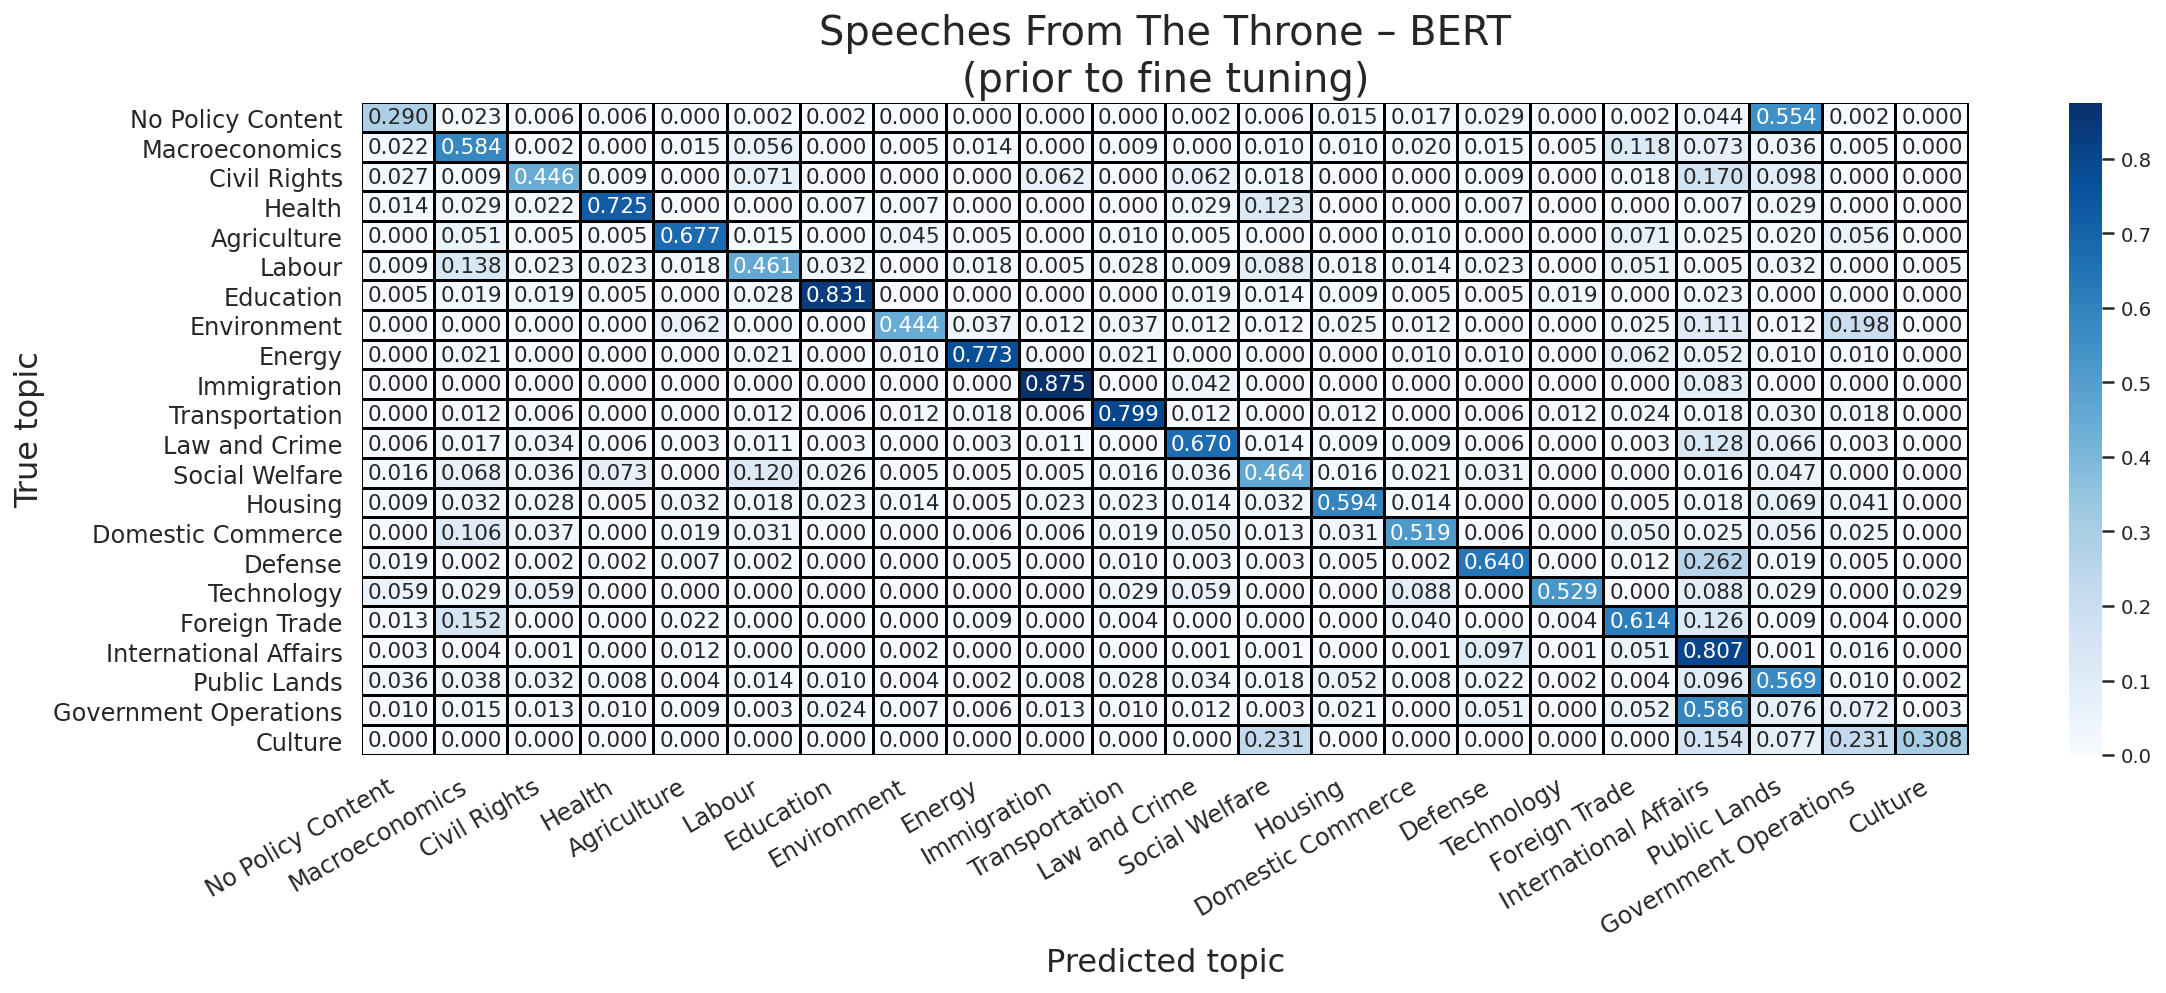

In [66]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize = (18,6))
  sns. set(font_scale=0.9)
  hmap = sns.heatmap(confusion_matrix, annot=True,fmt='.3f', cmap="Blues", linewidths=1, linecolor='black')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right',size=12)
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right',size=12)
  plt.ylabel('True topic',fontdict={"size":16})
  plt.title('Speeches From The Throne – BERT\n(prior to fine tuning)', fontsize =20)
  plt.xlabel('Predicted topic',fontdict={"size":16});

cm = confusion_matrix(y_test, y_pred,normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Not really great. I will now fine tune the model bit, using just 15% of the data (+5% that used for validation) from the UK dataset:

In [67]:
uk.shape

(6624, 5)

In [68]:
print(len(train),len(test),len(val))

29 4 4


In [69]:
years=[i for i in uk.year.unique()]
train, test=train_test_split(years, test_size=0.86,random_state=RANDOM_SEED)
val, test= train_test_split(test, test_size=0.85,random_state=RANDOM_SEED)
df_train=pd.DataFrame(columns=uk.columns)
df_test=pd.DataFrame(columns=uk.columns)
df_val=pd.DataFrame(columns=uk.columns)
for i in train:
  df_train=pd.concat([df_train, uk[uk.year==i]])
for i in test:
  df_test=pd.concat([df_test, uk[uk.year==i]])
for i in val:
  df_val=pd.concat([df_val, uk[uk.year==i]])

print (df_train.shape, df_val.shape, df_test.shape)

(1015, 5) (875, 5) (4734, 5)


In [70]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [71]:
data = next(iter(train_data_loader))
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [72]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [73]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  #if val_acc > best_accuracy:
    #torch.save(model.state_dict(), 'best_model_state_UK.bin')
    #best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.169617962092161 accuracy 0.6334975369458128
Val   loss 1.4458696459020888 accuracy 0.6822857142857144

Epoch 2/10
----------
Train loss 0.9574603950604796 accuracy 0.7596059113300492
Val   loss 1.2894610975469862 accuracy 0.6971428571428572

Epoch 3/10
----------
Train loss 0.6187666738405824 accuracy 0.8246305418719211
Val   loss 1.214575543999672 accuracy 0.7062857142857143

Epoch 4/10
----------
Train loss 0.4586723924148828 accuracy 0.8679802955665024
Val   loss 1.2176054854478155 accuracy 0.7165714285714286

Epoch 5/10
----------
Train loss 0.34949057671474293 accuracy 0.8886699507389162
Val   loss 1.1676467529364996 accuracy 0.7371428571428572

Epoch 6/10
----------
Train loss 0.30549571302253753 accuracy 0.9014778325123152
Val   loss 1.1522206286234515 accuracy 0.7291428571428572

Epoch 7/10
----------
Train loss 0.20437953839427792 accuracy 0.9369458128078817
Val   loss 1.191211645092283 accuracy 0.7325714285714287

Epoch 8/10
----------
Train loss 0.18971977086039

In [74]:
#if we already have a saved trained model, we can load it with the following lines, insted of training it:
#model = TopicClassifier(len(class_names))
#model.load_state_dict(torch.load('best_model_state_UK.bin'))
#model = model.to(device)


Let's now see if, after fine tuning it, the model improved its accuracy

In [75]:
y_sentences, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [76]:
print(classification_report(y_test, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

    No Policy Content       0.96      0.96      0.96       357
       Macroeconomics       0.71      0.65      0.68       409
         Civil Rights       0.54      0.45      0.49        71
               Health       0.70      0.77      0.73        98
          Agriculture       0.68      0.73      0.71       158
               Labour       0.44      0.54      0.49       145
            Education       0.86      0.85      0.86       146
          Environment       0.59      0.55      0.57        53
               Energy       0.71      0.72      0.71        67
          Immigration       0.71      0.71      0.71        14
       Transportation       0.65      0.87      0.74       114
        Law and Crime       0.84      0.73      0.78       245
       Social Welfare       0.58      0.50      0.54       133
              Housing       0.66      0.63      0.65       158
    Domestic Commerce       0.56      0.53      0.54  

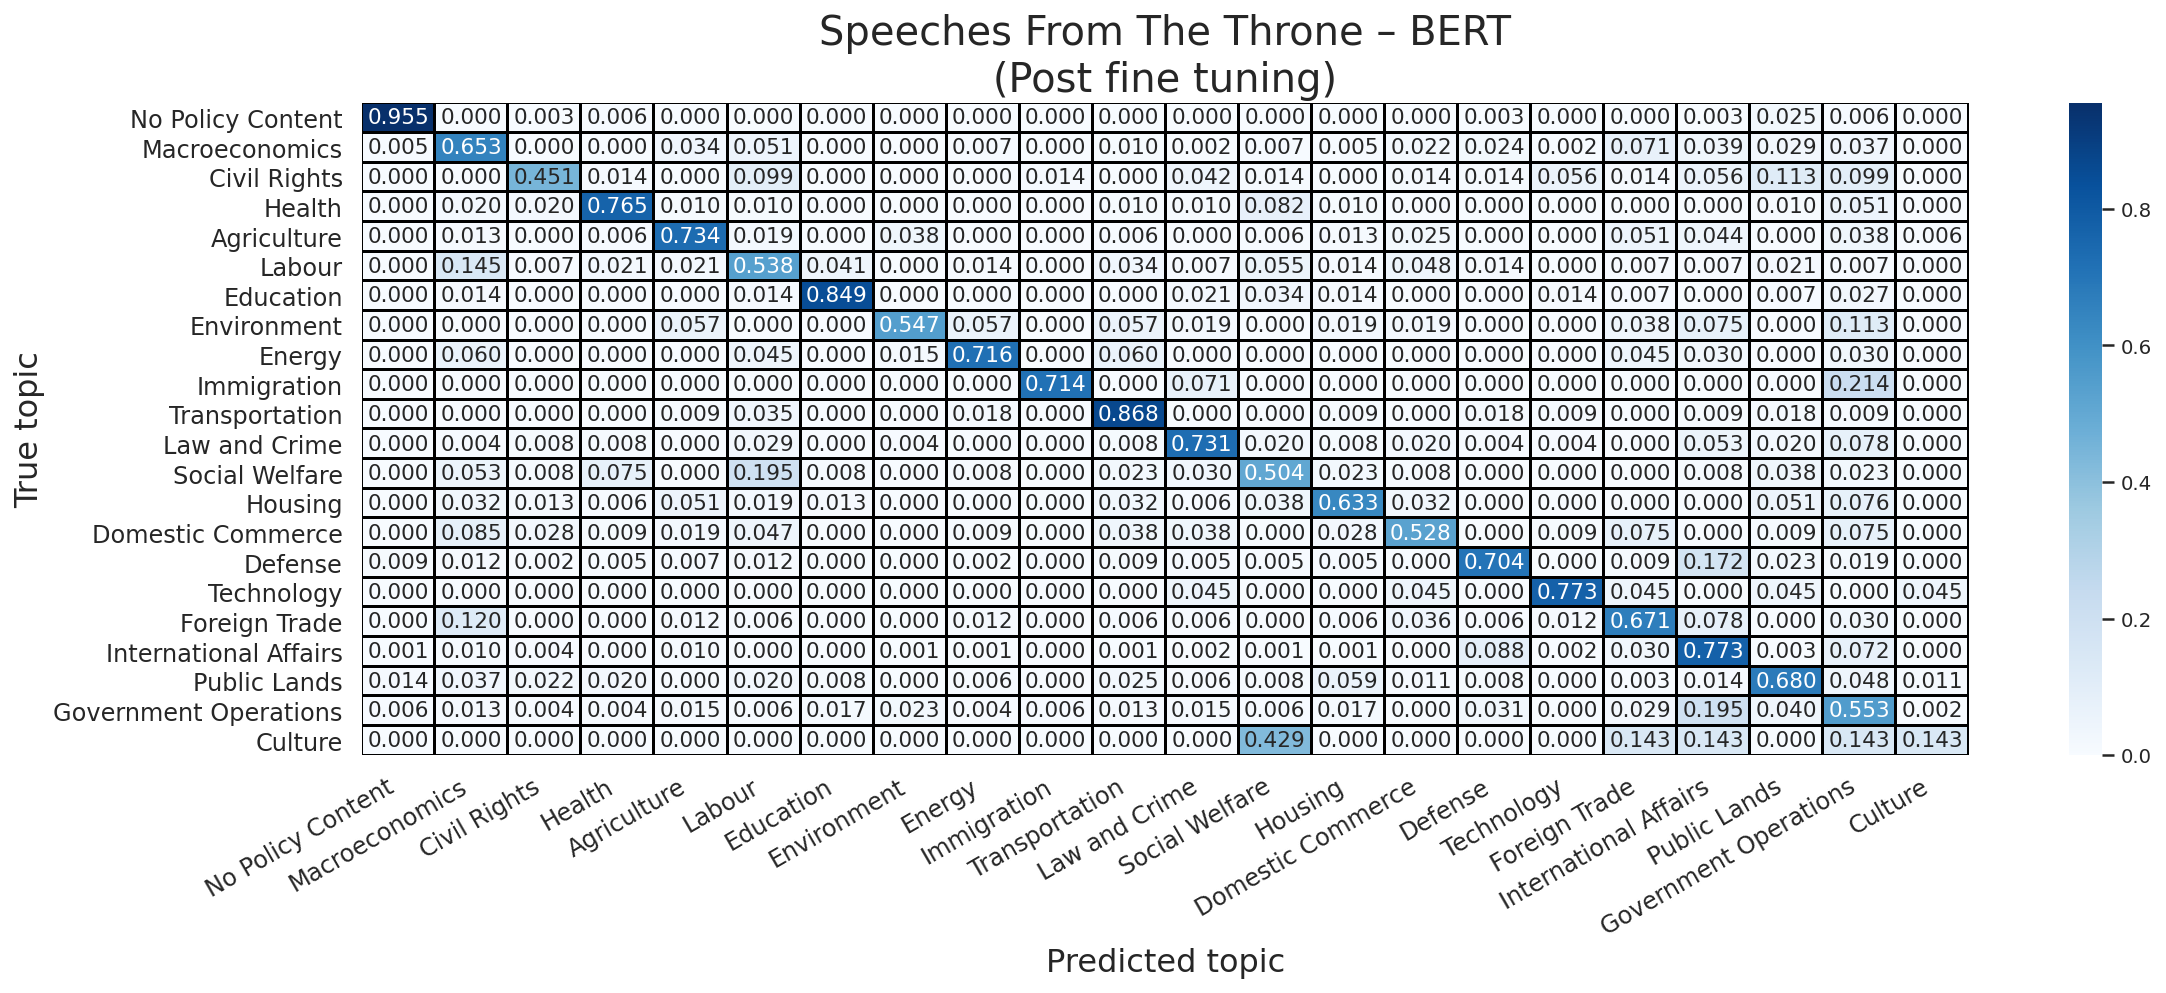

In [77]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize = (18,6))
  sns. set(font_scale=0.9)
  hmap = sns.heatmap(confusion_matrix, annot=True,fmt='.3f', cmap="Blues", linewidths=1, linecolor='black')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right',size=12)
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right',size=12)
  plt.ylabel('True topic',fontdict={"size":16})
  plt.title('Speeches From The Throne – BERT\n(Post fine tuning)', fontsize =20)
  plt.xlabel('Predicted topic',fontdict={"size":16});

cm = confusion_matrix(y_test, y_pred,normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


[This guide](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) was used as reference for the present script.  